# Navigating Turbulent Odor Plumes Using Reinforcement Learning

This notebook uses the Q-learning algorithm of Reinforcement Learning (RL) to train virtual agents to navigate a 2D turbulent odor plume. Turbulent odor plumes are spatiotemporally complex: odor signals arrive in random, unpredictable bursts, and odor concentration does follow continuous gradients, making plume navigation a difficult task. Suprisingly, there has been no published work on applying RL algorithms to turbulent odor plume navigation. 

## Q-learning algorithm
Q-learning updates a state-action value function, $Q(a, s)$, which quantifies the value of taking action $a$ when in state $s$. This function is updated in time using the Q-learning algorithm. At each timestep, the navigator takes an action $A$ to go from state $S$ to state $S'$, using whatever policy (greedy, $\epsilon$-greedy, etc.), where it receives a reward $R$. Then $Q(A, S)$ is updated using a *greedy* update rule (hence *off-policy*):

$\begin{align}
 Q(A, S) \leftarrow Q(A, S) + \alpha[R + \gamma \max_a Q(a, S')  - Q(A, S)]
\end{align}$

Here, $\alpha < 1$ and $\gamma < 1$ are update step-size and learning rate -- both hyperparameters in the simulation.

### State space: $\{s\}$

Following results found recently for navigation of odor plumes by fruit flies, we assume that navigators rely on the frequency of odor hits. An odor hit is the time at which the signal surpassses a given threshold. Running average of hit frequency, $W_freq$, is found by convolving the binary time series of odor hit times $w(t)$ with an exponential kernel ($\tau = 2$ seconds):

$W_{freq} = \int^t_{-\infty} e^{-(t-t')/\tau} w(t')dt'$

We discretize the state space into low and high frequency,

$S_1$: $W_{freq} < \text{thresh}$

$S_2$: $W_{freq} >= \text{thresh}$

where $thresh$ is to be chosen

### Action space: $\{a\}$
The navigators move on a grid, and we assume that there are 4 actions:

$A_1$: turn upwind (i.e. left)
$A_2$: walk straight
$A_3$: turn randomly in one of the 4 directions
$A_4$: turn toward the plume centerline

The last action $A_4$ means that, in the plume cone, flies in the top half will turn downward, and flies in the bottom half will turn upward. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import sys
sys.path.append('src')
from utils import gen_plot

In [3]:
# Step size
alpha = 0.9

# Learning rate
gamma = 0.9

In [207]:
class centerline_upwind(object):
    """
    Reinforced learning simulation where navigators can i) go straight, 
    ii) turn upwind, iii) turn randomly, or iv), turn toward the 
    plume centerline.
    """
    
    def __init__(self):
        """
        Define video file and video parameters. This is universal for all RL algorithms.
        """
        
        self.vid_file = r'data/intermittent_smoke.avi'
        self.beg_frm = 500
        self.max_frms = 5000
        self.xy_step = 2
        self.num_steps = 3000
        self.x0_min = 500
        self.x0_max = 1400
        self.max_x = 1500
        self.max_y = 840
        self.y_center = 450
        self.y0_spread = 200
        
        # Number of parallel agents
        self.num_walkers = 1000
        
        
        # epsilon-greedy action selection
        self.epsilon = 0.05
    
    def def_states(self):
        """
        States are delineated by odor frequency, which is defined
        by an exponential timescale
        """
        
        self.odor_threshold = 100
        self.odor_vec_len = 500
        self.freq_bins = [-0.01, 2, 100]
        self.tau = 2
        self._num_states = len(self.freq_bins) - 1
        
    def def_actions(self):
        """
        Actions defined by motion `v' in run script
        """
        self._num_actions = 4
    
    def update_actions(self, Q, states, iS):
        """
        Get optimal actions from Q function
        """
        
        # Q for state and action at last timestep
        last_Q = Q[iS, states[iS], :, np.arange(self.num_walkers)].T

        # Binary array of size (num_actions, num_walkers) for previous state. Equals
        # `1' if that action is optimal (there can be degeneracies).
        opt_action_arr = 1.*(last_Q == np.amax(last_Q, axis=0))

        # From the optimal actions, choose randomly by random shifts around `1' + sorting
        opt_action_arr *= np.random.normal(1, 0.01, opt_action_arr.shape)
        actions = np.argmax(opt_action_arr, axis=0)

        # Epsilon-greedy action selection randomizes actions with prob = epsilon
        actions_to_flip = np.random.uniform(0, 1, self.num_walkers) > (1. - self.epsilon)
        random_actions = np.random.randint(0, self._num_actions, self.num_walkers)
        actions[actions_to_flip] = random_actions[actions_to_flip]

        return actions
    
    def update_xys(self, xs, ys, vs, actions, iS):
        """
        Update navigator positions given selected actions
        """
        
        _xs = xs[iS]
        _ys = ys[iS]

        _xs[_xs > self.max_x] = self.max_x
        _ys[_ys > self.max_y] = self.max_y
        _xs[_xs < 0] = 0
        _ys[_ys < 0] = 0

        # Actions give change in velocity v, 0-4; 0=right (downwind), 1=up (crosswind), 
        # 2=left (upwind), 3=down (crosswind). 
        # Actions: 
        #   0: go upwind (_v = 2)
        #   1: keep same direction (_v = v[iS])
        #   2: randomize direction (_v = random from 0 to 3)
        #   3: go toward centerline (_v = 1 or 3 depending on y)
        _vs = np.empty(self.num_walkers)*np.nan
        _vs[actions == 0] = 2
        _vs[actions == 1] = vs[iS, actions == 1]
        _vs[actions == 2] = np.random.randint(0, 4, np.sum(actions == 2))
        _vs[actions == 3] = (ys[iS, actions == 3] > self.y_center)*3 + \
                            (ys[iS, actions == 3] <= self.y_center)*1

        _xs[_vs == 0] += self.xy_step
        _ys[_vs == 1] += self.xy_step
        _xs[_vs == 2] -= self.xy_step
        _ys[_vs == 3] -= self.xy_step

        xs[iS + 1] = _xs
        ys[iS + 1] = _ys
        vs[iS + 1] = _vs

        return xs, ys, vs
        
    def update_states(self, xs, ys, odors, states, frm, fps, iS):
        """
        Update the odor vector and the next state based on odor signal
        """
        
        # Whiff is binary; 1 if greater than odor threshold
        whfs = 1.*(frm[(ys[iS], xs[iS])] > self.odor_threshold)

        # Append new signal to odor vector (odors in recent past)
        odors = np.roll(odors, -1, axis=0)
        odors[-1] = whfs

        # Frequency of odor whiffs by discounting recent odor hits (diff of odors) 
        # with a 2s decaying exponential
        whf_freqs = np.sum((np.diff(odors, axis=0) > 0).T*
                          np.exp(-np.arange(odors.shape[0] - 1).T/self.tau/fps)[::-1], 
                          axis=1)
        
        states[iS + 1] = np.digitize(whf_freqs, self.freq_bins, right=True) - 1
            
        return odors, states
        
    def run(self, seed=0):
        
        np.random.seed(seed)
        
        cap = cv2.VideoCapture(self.vid_file)
        cap.set(cv2.CAP_PROP_POS_FRAMES, self.beg_frm)
        fps = cap.get(cv2.CAP_PROP_FPS)
    
        xs = np.zeros((self.num_steps, self.num_walkers), dtype=int)
        ys = np.zeros((self.num_steps, self.num_walkers), dtype=int)
        vs = np.zeros((self.num_steps, self.num_walkers), dtype=int)
        states = np.zeros((self.num_steps, self.num_walkers), dtype=int)
        Q = np.ones((self.num_steps, self._num_states, self._num_actions, self.num_walkers))
        
        # Binary vectory indicating if path reached source
        ends = np.zeros(self.num_walkers)
        
        # Length of trajectory from initial point to source in timesteps
        path_lengths = np.ones(self.num_walkers)*self.num_steps
        
        # Initial x,y are random; initial motion is upwind (v = 2)
        xs[0] = np.random.randint(self.x0_min, 
                                  self.x0_max, 
                                  self.num_walkers)
        ys[0] = np.random.randint(self.y_center - self.y0_spread, 
                                  self.y_center + self.y0_spread, 
                                  self.num_walkers)
        vs[0] = np.ones(self.num_walkers)*2
        
        # Holds odor vector to define states
        odors = np.zeros((self.odor_vec_len, self.num_walkers))

        for iS in range(self.num_steps - 1):
            print (iS, end = " ", flush=True)
            
            # Update actions and positions based on optimal actions
            actions = self.update_actions(Q, states, iS)
            xs, ys, vs = self.update_xys(xs, ys, vs, actions, iS)
            
            # Mark those that reached the source at this step and how long to do so
            _ends = (xs[iS] < 150)*(abs(ys[iS] - self.y_center) < 50)
            path_lengths[(ends == 0)*_ends] = iS
            ends[_ends] = 1
            
            # Grab odor signal from current frame; cycle video if reached end
            if iS > self.max_frms:
                cap = cv2.VideoCapture(vid_file)
                cap.set(cv2.CAP_PROP_POS_FRAMES, self.beg_frm)
            ret, frm = cap.read()
            frm = frm[:, :, 2]
            
            # Update odor vector, states, and rewards
            odors, states = self.update_states(xs, ys, odors, states, frm, fps, iS)
            rewards = (odors[-1] - odors[-2]) > 0
            
            # All Qs at this timestep are the same as last, except the current 
            # (state, action) pair, which is being updated
            Q[iS + 1] = Q[iS]
            Q[iS + 1, states[iS], actions, np.arange(self.num_walkers)] = \
                Q[iS, states[iS], actions, np.arange(self.num_walkers)] + \
                alpha*(rewards + gamma*np.amax(Q[iS, states[iS + 1], :, 
                np.arange(self.num_walkers)].T, axis=0) - \
                Q[iS, states[iS], actions, np.arange(self.num_walkers)])
        
        return xs, ys, Q, path_lengths

In [208]:
a = centerline_upwind()
a.def_actions()
a.def_states()
xs, ys, Q, path_lengths = a.run()

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

1861 1862 1863 1864 1865 1866 1867 1868 1869 1870 1871 1872 1873 1874 1875 1876 1877 1878 1879 1880 1881 1882 1883 1884 1885 1886 1887 1888 1889 1890 1891 1892 1893 1894 1895 1896 1897 1898 1899 1900 1901 1902 1903 1904 1905 1906 1907 1908 1909 1910 1911 1912 1913 1914 1915 1916 1917 1918 1919 1920 1921 1922 1923 1924 1925 1926 1927 1928 1929 1930 1931 1932 1933 1934 1935 1936 1937 1938 1939 1940 1941 1942 1943 1944 1945 1946 1947 1948 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038 2039 2040 2041 2042 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059 2060 

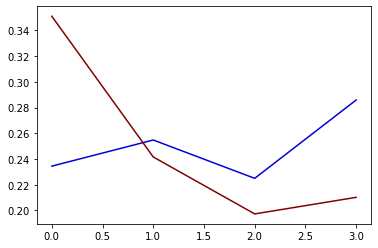

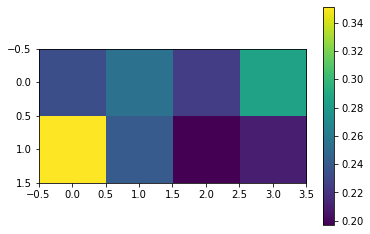

In [209]:
Q_norm = np.zeros((a._num_states, a._num_actions))
for iW in range(a.num_walkers):
    Q_norm += Q[int(path_lengths[iW]) - 1, :, :, iW]
Q_norm = (Q_norm.T/np.sum(Q_norm, axis=-1)).T        

colors = plt.cm.seismic(np.linspace(0.2, 1.0, a._num_states))
for i in range(a._num_states):
    plt.plot(Q_norm[i], color=colors[i])
plt.show()

plt.imshow(Q_norm)
plt.colorbar()
plt.show()

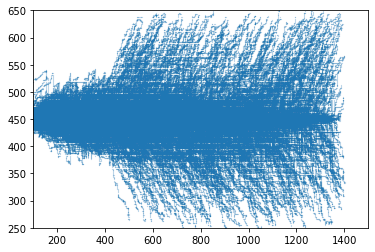

In [210]:
plt.scatter(xs, ys, s = 0.01)
plt.xlim(100, 1500)
plt.ylim(450 - 200, 450 + 200)
plt.show()
